In [68]:
import pickle
import numpy as np
import pandas as pd
from heuristic import *
from utils import *
pd.set_option('display.max_rows',500)
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
%matplotlib inline

def get_df_for_heuristic():
    df = pd.read_csv("/home1/07346/ashukla/ThreeStageModel/data/192_Scenario/Final_Input1.csv")
    directions = ["w", "wnw", "nw", "nnw", "n", "nne"]
    categories = ["2", "3", "4", "5"]
    forward_speeds = ["05", "10", "15", "25"]
    lister = []
    for i in directions:
        for j in range(len(categories)):
            for k in range(len(forward_speeds)):
                lister.append("max_flood_level_" + i +"_" + categories[j] + "_" + forward_speeds[k])
    df = df[list(df.columns[0:9]) + lister]
    df_sub = df[["SubNum", "load"]].groupby("SubNum").sum()
    df_flood = df[["SubNum"] + lister]
    df_flood = df_flood.drop_duplicates().set_index("SubNum") # drop duplicates
    df_flood = df_flood.loc[(df_flood.sum(axis=1) != 0), :] # drop substations that are not flooded
    """df_sub has load demand for all the substations"""
    """df_flood has only flooded substations"""
    return df, df_sub, df_flood

def return_model_scenarios():
    directions = ["w", "wnw", "nw", "nnw", "n", "nne"]
    categories = ["2", "3", "4", "5"]
    forward_speeds = ["05", "10", "15", "25"]
    model_scenarios = {}
    counter = 0
    for i in directions:
        for j in range(len(categories)-1):
            for k in range(len(forward_speeds)-1):
                lister = []
                lister.append("max_flood_level_" + i +"_" + categories[j] + "_" + forward_speeds[k])
                lister.append("max_flood_level_" + i +"_" + categories[j] + "_" + forward_speeds[k+1])
                #lister.append("max_flood_level_" + i +"_" + categories[j] + "_" + forward_speeds[k+2])
                lister.append("max_flood_level_" + i +"_" + categories[j+1] + "_" + forward_speeds[k])
                lister.append("max_flood_level_" + i +"_" + categories[j+1] + "_" + forward_speeds[k+1])
                #lister.append("max_flood_level_" + i +"_" + categories[j+1] + "_" + forward_speeds[k+2])
                model_scenarios[counter] = lister
                counter = counter + 1
    return model_scenarios

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki])
                       for i in range(N+1) ]
    # Return colormap object.
    return mcolors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

df, df_sub, df_flood = get_df_for_heuristic()
model_scenarios = return_model_scenarios()

with open('optimization_solution_list.pickle', 'rb') as handle:
    optimization_list = pickle.load(handle)

/tmp/ipykernel_138828/1827008612.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 720x360 with 0 Axes>

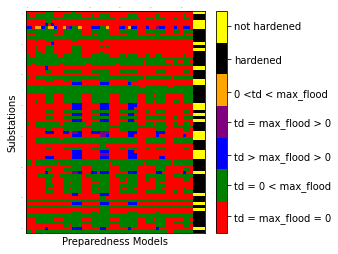

In [90]:
voll = 6000
df_plot = pd.DataFrame(index=df_flood.index, columns=np.arange(0,54,1))
lister = []
for i in df_plot.index:
    for j in df_plot.columns:
        temp = str(i) + "_" + str(j)
        td_value = optimization_list[voll][1][temp]
        flood = df_flood.loc[i, model_scenarios[j]].max()
        if td_value == 0:
            if flood == 0:
                df_plot.loc[i,j] = 0.0
            else:
                df_plot.loc[i,j] = 1.0
        else:
            if td_value > flood:
                df_plot.loc[i,j] = 2.0
            elif td_value == flood:
                df_plot.loc[i,j] = 3.0
            else:
                df_plot.loc[i,j] = 4.0
    if optimization_list[voll][0][i] > 0:
        lister.append(5.0)
    else:
        lister.append(6.0)
    
df_plot["hardening"] = lister
df_plot["hardening1"] = lister
df_plot["hardening2"] = lister
df_plot["hardening3"] = lister

colormap_mapping = {
    0.0: 'red',
    1.0: 'green',
    2.0: 'blue',
    3.0: 'purple',
    4.0: 'orange',
    5.0: "black",
    6.0: "yellow"
}
colors = [colormap_mapping[i] for i in range(7)]
cmap = mpl.colors.ListedColormap(colors)

plt.figure(figsize=(10,5))
plt.matshow(df_plot.iloc[:,:].values.astype(float),cmap=cmap)
cb = plt.colorbar(shrink=0.8)
labels = np.arange(0,7, 0.2)
loc    = [0.45,1.3,2.1,3,3.8,4.7,5.6]
cb.set_ticks(loc)
l1 = ["td = max_flood = 0", "td = 0 < max_flood", "td > max_flood > 0", "td = max_flood > 0",
      "0 <td < max_flood", "hardened", "not hardened"]
      
cb.set_ticklabels(l1)
plt.tick_params(which = 'both', size = 0, labelsize = 0)
plt.tight_layout()
plt.xlabel("Preparedness Models")
plt.ylabel("Substations")
#plt.savefig("output_plots/voll_variation_" + str(voll) + ".pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
model_name = "modified_td_prep_12"
main_path = "/work/07346/ashukla/ls6/ThreeStageModel/output/" + model_name + "/"


main_path = path_str + str(voll_value) + "/"
with open(main_path + "model_params.json", 'r') as f:
    params = json.load(f)   
params["path_to_input"] = os.getcwd() + "/data/192_Scenario/"
base_model = three_stage_model(params, model_scenarios)
base_model.model.update()
sol_path = main_path + "solution.sol"
base_model.model.read(sol_path)
base_model.model.update()

hardening_decisions = {}
tiger_dam_decisions = {}

for sub_id in df_flood.index:
    hardening_decisions[sub_id] = int(base_model.x_mit[sub_id].Start*params["mit_level"])
for sub_id in df_flood.index:
    for j in model_scenarios:
        tiger_dam_decisions[str(sub_id) + "_" + str(j)] = int(base_model.x_prep[sub_id,j].Start*params["prep_level"])
